In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
# from torch.utils.data import DataLoader


2023-09-10 11:37:00.686850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=10000'
headers = {'X-CoinAPI-Key' : '42D2F86D-F548-43D2-96C1-D7DB039EF63E'}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-10T00:00:00.0000000Z', 'time_period_end': '2023-09-11T00:00:00.0000000Z', 'time_open': '2023-09-10T00:00:12.4050000Z', 'time_close': '2023-09-10T15:24:32.8160000Z', 'price_open': 1635.6, 'price_high': 1635.6, 'price_low': 1612.2, 'price_close': 1617.1, 'volume_traded': 1326.89491026, 'trades_count': 2061}, {'time_period_start': '2023-09-09T00:00:00.0000000Z', 'time_period_end': '2023-09-10T00:00:00.0000000Z', 'time_open': '2023-09-09T00:00:01.0110000Z', 'time_close': '2023-09-09T23:58:29.6580000Z', 'price_open': 1636, 'price_high': 1637.3, 'price_low': 1629.7, 'price_close': 1635.3, 'volume_traded': 1588.74111545, 'trades_count': 5245}, {'time_period_start': '2023-09-08T00:00:00.0000000Z', 'time_period_end': '2023-09-09T00:00:00.0000000Z', 'time_open': '2023-09-08T00:00:05.8280000Z', 'time_close': '2023-09-08T23:59:25.6100000Z', 'price_open': 1647.8, 'price_high': 1658.1, 'price_low': 1616.1, 'price_close': 1636, 'volume_traded': 3926.05948046, 'trades_c

In [13]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:12.4050000Z,2023-09-10T15:24:32.8160000Z,1635.6,1635.6,1612.2,1617.1,1326.894910,2061
1,2023-09-09T00:00:00.0000000Z,2023-09-10T00:00:00.0000000Z,2023-09-09T00:00:01.0110000Z,2023-09-09T23:58:29.6580000Z,1636.0,1637.3,1629.7,1635.3,1588.741115,5245
2,2023-09-08T00:00:00.0000000Z,2023-09-09T00:00:00.0000000Z,2023-09-08T00:00:05.8280000Z,2023-09-08T23:59:25.6100000Z,1647.8,1658.1,1616.1,1636.0,3926.059480,10596
3,2023-09-07T00:00:00.0000000Z,2023-09-08T00:00:00.0000000Z,2023-09-07T00:00:05.9800000Z,2023-09-07T23:59:45.6740000Z,1632.2,1658.1,1622.6,1647.9,5015.308811,8506
4,2023-09-06T00:00:00.0000000Z,2023-09-07T00:00:00.0000000Z,2023-09-06T00:00:24.4450000Z,2023-09-06T23:59:48.4300000Z,1634.0,1668.6,1608.8,1632.2,5221.802148,5166


In [21]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


In [50]:
close = data['Close']

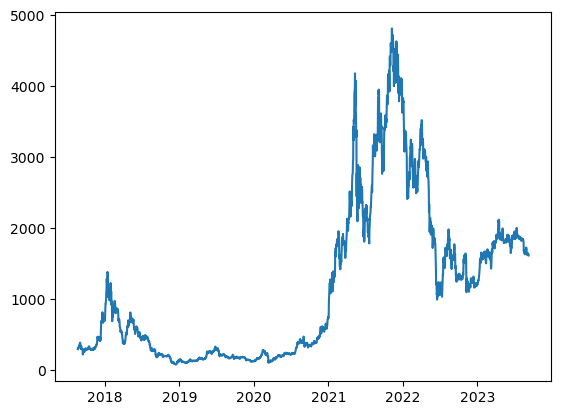

In [51]:
#plot historical eth price
plt.plot(close)

In [64]:
# #scale data with min/max scaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# close_scaled = scaler.fit_transform(close)

# close_scaled

In [65]:
# build 1 week lookback for lstm training
# def prepare_dataframe_for_lstm(data, n_steps):
#     data = dc(data)
    
#     for i in range(1, n_steps+1):
#         data[f'Close(t-{i})'] = data['Close'].shift(i)
        
#     data.dropna(inplace=True)
    
#     return data

# lookback = 7
# shifted_df = prepare_dataframe_for_lstm(data, lookback)
# shifted_df

In [66]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [67]:
WINDOW_SIZE = 7
X1, y1 = df_to_X_y(close, WINDOW_SIZE)
X1.shape, y1.shape

((2196, 7, 1), (2196,))

In [68]:
#convert from df to numpy array
# shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np

In [69]:
# shifted_df_as_np.shape

In [70]:
#scale data with min/max scaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X1_scaled = scaler.fit_transform(X1)

# X1_scaled

In [71]:
#check shapes
# X = shifted_df_as_np[:, 1:]
# y = shifted_df_as_np[:, 0]

# X.shape, y.shape

In [72]:
# X = dc(np.flip(X, axis=1))
# X

In [73]:
X_train1, y_train1 = X1[:1596], y1[:1596]
X_val1, y_val1 = X1[1596:1896], y1[1596:1896]
X_test1, y_test1 = X1[1896:], y1[1896:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1596, 7, 1), (1596,), (300, 7, 1), (300,), (300, 7, 1), (300,))

In [74]:
model = Sequential()
model.add(InputLayer((7, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [75]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [76]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp])

Epoch 1/10
45/50 [==========================>...] - ETA: 0s - loss: 2166826.7500 - root_mean_squared_error: 1472.0145

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 7s 111ms/step - loss: 2201934.5000 - root_mean_squared_error: 1483.8917 - val_loss: 4847793.5000 - val_root_mean_squared_error: 2201.7705
Epoch 2/10
48/50 [===========================>..] - ETA: 0s - loss: 2171457.2500 - root_mean_squared_error: 1473.5865

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 6s 125ms/step - loss: 2201014.2500 - root_mean_squared_error: 1483.5815 - val_loss: 4846649.5000 - val_root_mean_squared_error: 2201.5107
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 2200567.2500 - root_mean_squared_error: 1483.4309

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 99ms/step - loss: 2200567.2500 - root_mean_squared_error: 1483.4309 - val_loss: 4846123.5000 - val_root_mean_squared_error: 2201.3914
Epoch 4/10
47/50 [===========================>..] - ETA: 0s - loss: 2170533.7500 - root_mean_squared_error: 1473.2732

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 102ms/step - loss: 2200113.0000 - root_mean_squared_error: 1483.2778 - val_loss: 4844335.0000 - val_root_mean_squared_error: 2200.9851
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 2199065.2500 - root_mean_squared_error: 1482.9246

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 6s 114ms/step - loss: 2199065.2500 - root_mean_squared_error: 1482.9246 - val_loss: 4841126.5000 - val_root_mean_squared_error: 2200.2561
Epoch 6/10
48/50 [===========================>..] - ETA: 0s - loss: 2211220.5000 - root_mean_squared_error: 1487.0173

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 103ms/step - loss: 2197611.7500 - root_mean_squared_error: 1482.4344 - val_loss: 4838962.0000 - val_root_mean_squared_error: 2199.7642
Epoch 7/10
47/50 [===========================>..] - ETA: 0s - loss: 2229272.0000 - root_mean_squared_error: 1493.0747

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 105ms/step - loss: 2196383.7500 - root_mean_squared_error: 1482.0201 - val_loss: 4835548.0000 - val_root_mean_squared_error: 2198.9880
Epoch 8/10
46/50 [==========================>...] - ETA: 0s - loss: 2243348.7500 - root_mean_squared_error: 1497.7812

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 6s 114ms/step - loss: 2195421.2500 - root_mean_squared_error: 1481.6954 - val_loss: 4833392.0000 - val_root_mean_squared_error: 2198.4976
Epoch 9/10
49/50 [============================>.] - ETA: 0s - loss: 2206181.0000 - root_mean_squared_error: 1485.3219

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 110ms/step - loss: 2194463.0000 - root_mean_squared_error: 1481.3719 - val_loss: 4830701.5000 - val_root_mean_squared_error: 2197.8857
Epoch 10/10
44/50 [=========================>....] - ETA: 0s - loss: 2124319.2500 - root_mean_squared_error: 1457.5045

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


50/50 [==============================] - 5s 104ms/step - loss: 2193032.2500 - root_mean_squared_error: 1480.8890 - val_loss: 4828531.0000 - val_root_mean_squared_error: 2197.3918


In [77]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [79]:
train_predictions = model.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

50/50 [==============================] - 1s 4ms/step


,Train Predictions,Actuals
0,5.787124,347.55
1,5.777595,346.68
2,5.770436,372.37
3,5.757916,383.03
4,5.747528,388.00
...,...,...
1591,5.504556,3408.35
1592,5.504556,3196.03
1593,5.504556,3081.09
1594,5.504556,3151.58


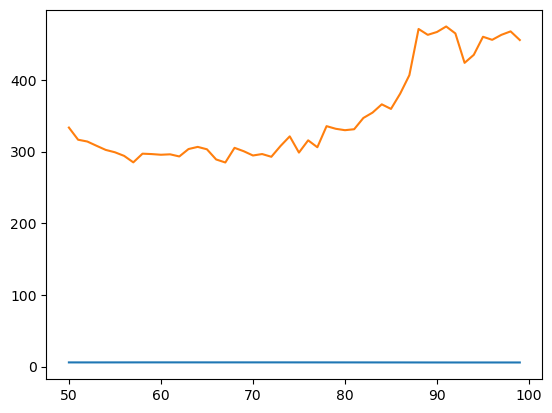

In [80]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [82]:
val_predictions = model.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,5.504556,3242.74
1,5.504556,3374.65
2,5.504556,3241.82
3,5.504556,3308.82
4,5.504556,3329.71
...,...,...
295,5.506627,1518.60
296,5.507366,1531.10
297,5.507195,1645.20
298,5.506035,1627.40


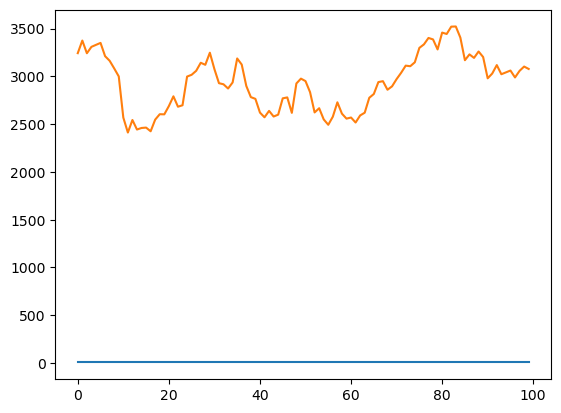

In [83]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [84]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,5.506739,1568.3
1,5.506740,1334.2
2,5.511671,1099.7
3,5.526983,1294.9
4,5.513371,1284.8
...,...,...
295,5.506121,1632.2
296,5.506135,1647.9
297,5.506014,1636.0
298,5.506104,1635.3


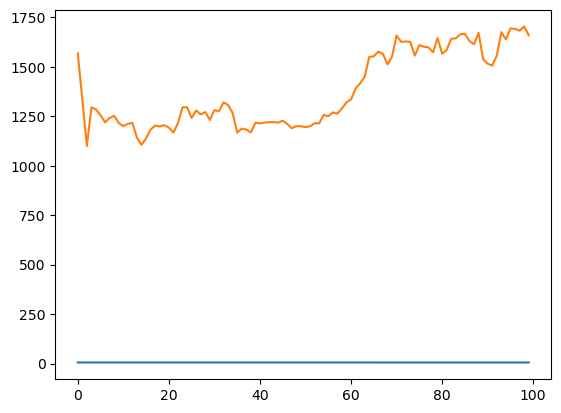

In [85]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [86]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

10/10 [==============================] - 0s 3ms/step


(     Predictions  Actuals
 0       5.506739   1568.3
 1       5.506740   1334.2
 2       5.511671   1099.7
 3       5.526983   1294.9
 4       5.513371   1284.8
 ..           ...      ...
 295     5.506121   1632.2
 296     5.506135   1647.9
 297     5.506014   1636.0
 298     5.506104   1635.3
 299     5.506110   1617.1
 
 [300 rows x 2 columns],
 2797676.5824264595)

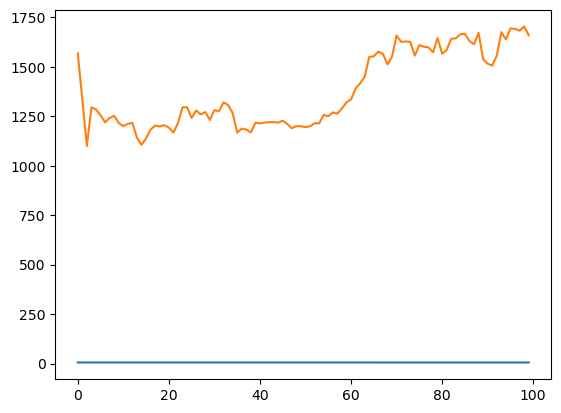

In [87]:
plot_predictions1(model, X_test1, y_test1)